In [1]:
import os
os.chdir('/content/drive/My Drive/DATA SCIENCE/DEEP_LEARNING/RNN LSTM Stock Market Prediction and Forecasting')

# **Stock Prices Prediction Using Machine Learning and Deep Learning Techniques (with Python codes)**

## **Introduction**

Borsaların nasıl performans göstereceğini tahmin etmek en zor şeylerden biri. Tahminlerde yer alan pek çok faktör vardır - fizyolojik, rasyonel ve irrasyonel davranışlar vs. gibi fiziksel faktörler. Tüm bu unsurlar hisse fiyatlarını oynak hale getirmek ve yüksek doğruluk derecesi ile tahmin edilmesini çok zorlaştırmak için bir araya gelmektedir.

Makine öğrenimini bu alanda oyun değiştirici olarak kullanabilir miyiz? Bir kuruluşla ilgili en son duyurular, üç aylık gelir sonuçları vb. Gibi özellikleri kullanarak, makine öğrenimi teknikleri daha önce görmediğimiz kalıpları ve içgörüleri ortaya çıkarma potansiyeline sahiptir ve bunlar hatasız doğru tahminler yapmak için kullanılabilir.

Bu makalede, halka açık bir şirketin hisse senedi fiyatları ile ilgili geçmiş verilerle çalışacağız. Ortalama ve doğrusal regresyon gibi basit algoritmalardan başlayarak bu şirketin gelecekteki hisse senedi fiyatını tahmin etmek için bir makine öğrenme algoritmaları karışımı uygulayacağız ve daha sonra Auto ARIMA ve LSTM gibi gelişmiş tekniklere geçeceğiz.

Bu makalenin arkasındaki ana fikir, bu algoritmaların nasıl uygulandığını göstermektir. Tekniği kısaca anlatacağım ve gerektiğinde kavramları düzeltmek için ilgili bağlantılar sunacağım. Zaman serileri dünyasına yeni geliyorsanız, önce aşağıdaki makaleleri incelemenizi öneririz:

- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/?utm_source=blog&utm_medium=stockmarketpredictionarticle
- https://courses.analyticsvidhya.com/courses/creating-time-series-forecast-using-python?utm_source=blog&utm_medium=stockmarketpredictionarticle




## **Understanding the Problem Statement**

Yakında bu makalenin uygulama bölümüne bakacağız, ancak önce çözmeyi amaçladığımız şeyi belirlemek önemlidir. Genel olarak, borsa analizi iki kısma ayrılır: Temel Analiz ve Teknik Analiz.

- Temel Analiz, şirketin gelecekteki kârlılığını mevcut iş ortamı ve finansal performans temelinde analiz etmeyi içerir. 
- Teknik Analiz ise, tabloların okunmasını ve borsadaki eğilimleri belirlemek için istatistiksel rakamların kullanılmasını içerir.

Tahmin edebileceğiniz gibi, odak noktamız teknik analiz bölümünde olacaktır. Quandl'den bir veri kümesi kullanacağız (burada çeşitli hisse senetleri için geçmiş verileri bulabilirsiniz) ve bu özel proje için, verileri 'Tata Global Beverages' için kullandım.

İlk önce veri kümesini yükleyeceğiz ve sorun için hedef değişkeni tanımlayacağız:

In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('AAPL.csv')

#print the head
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-08-06 00:00:00+00:00,115.13,116.50,114.115,115.97,52903040,106.574181,107.842371,105.634610,107.351757,52903040,0.52,1.0
1,AAPL,2015-08-07 00:00:00+00:00,115.52,116.25,114.500,114.58,38670405,106.935199,107.610949,105.990999,106.065054,38670405,0.00,1.0
2,AAPL,2015-08-10 00:00:00+00:00,119.72,119.99,116.530,116.53,54951597,110.823078,111.073013,107.870141,107.870141,54951597,0.00,1.0
3,AAPL,2015-08-11 00:00:00+00:00,113.49,118.18,113.330,117.81,97082814,105.056057,109.397522,104.907947,109.055019,97082814,0.00,1.0
4,AAPL,2015-08-12 00:00:00+00:00,115.24,115.42,109.630,112.53,101685610,106.676007,106.842630,101.482911,104.167399,101685610,0.00,1.0


In [2]:
df.shape

(1257, 14)

Veri kümesinde birden çok değişken vardır - Date (tarih), Open(açık), High(yüksek), Low(düşük), Last(son), Close(yakın), Total Trade Quantity(toplam_ticaret_quantity) ve Turnover(ciro).

- Aç ve Kapat sütunları, hisse senedinin belirli bir günde işlem gördüğü başlangıç ​​ve nihai fiyatı temsil eder. 
- Yüksek, Düşük ve Son, gün için payın maksimum, minimum ve son fiyatını temsil eder. 
- Toplam Ticaret Miktarı, gün içinde satın alınan veya satılan hisse sayısıdır ve Ciro (Lacs), belirli bir tarihte belirli bir şirketin cirosudur.

Dikkat edilmesi gereken bir başka önemli nokta, pazarın hafta sonları ve resmi tatillerde kapalı olmasıdır.Yukarıdaki tabloya tekrar dikkat edin, bazı tarih değerleri eksik - 2/10/2018, 6/10/2018, 7/10/2018. Bu tarihlerden ikincisi ulusal bayram, hafta sonu 6. ve 7. günler.

Kâr veya zarar hesaplaması genellikle gün için bir hisse senedinin kapanış fiyatı ile belirlenir, bu nedenle kapanış fiyatını hedef değişken olarak değerlendireceğiz. Verilerimizde nasıl şekillendiğini anlamak için hedef değişkeni çizelim:


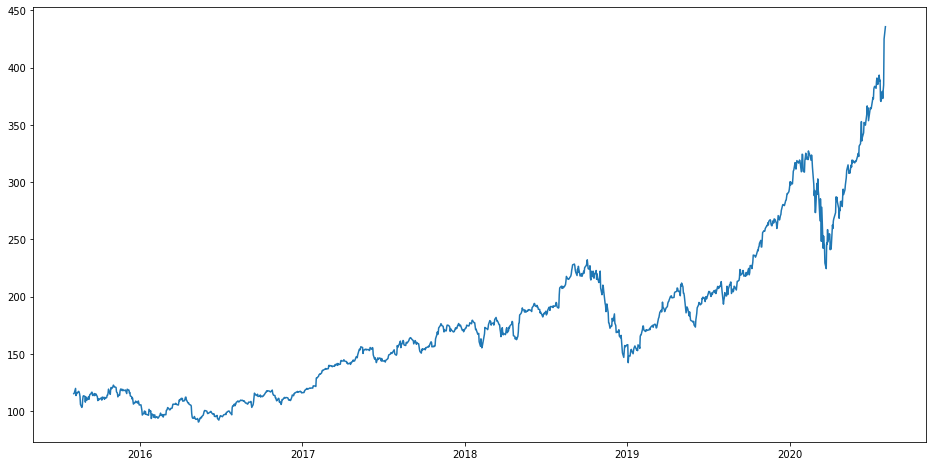

In [5]:
#setting index as date
df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')
df.index = df['date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')

In [7]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

927/927 - 22s - loss: 5.8642e-04


In [8]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

11.371649102994109

C:\Users\tor23\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


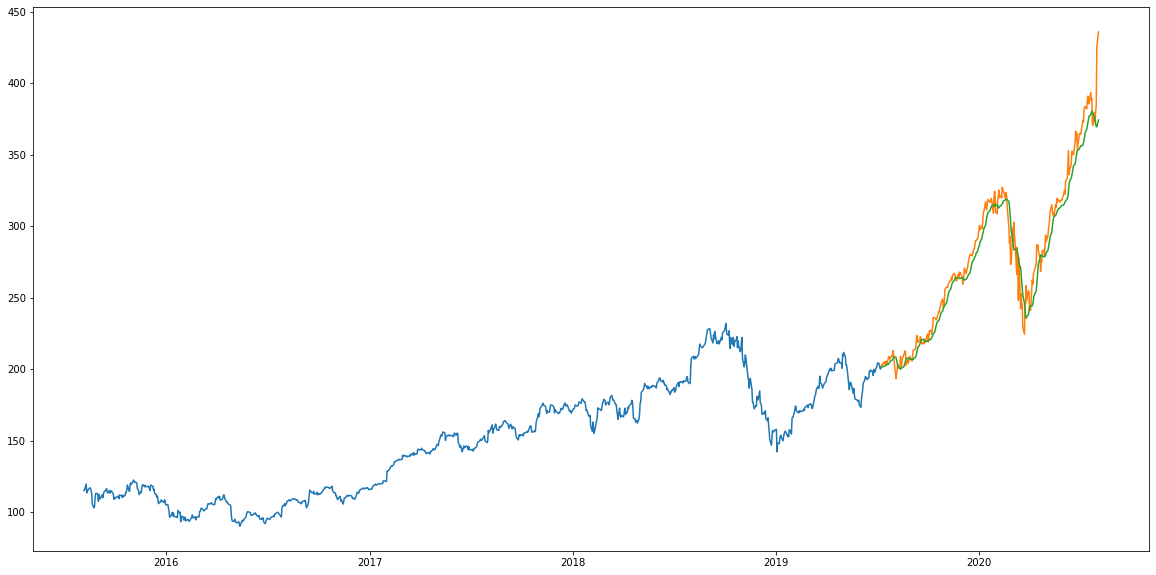

In [10]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])